In [16]:
import pandas as pd
import os
from google.cloud import bigquery
import json
from google.oauth2 import service_account
import db_dtypes 

In [17]:
# Obtain the key from the environment variable
service_account_key =os.getenv('GCP_ACCESS_KEY')
if not service_account_key:
    raise ValueError("The GCP_SERVICE_ACCOUNT_KEY environment variable is not set")

key_data = json.loads(service_account_key)

credentials = service_account.Credentials.from_service_account_info(
    key_data,
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)


In [18]:
service_acc_key=os.getenv('GCP_ACCESS_KEY')

In [19]:
project_id = os.getenv('GOOGLE_PROJECT_MAIN_FP')

In [ ]:
# Colab setup
# projext_id = 'main-fp'
# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated')

In [7]:
# client = bigquery.Client(project=project_id) Colab setup


In [20]:
client = bigquery.Client(credentials=credentials,project=project_id)

In [21]:
sql = """
SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` LIMIT 10
 """

In [11]:
# import pandas_gbq
# df = pandas_gbq.read_gbq(sql, project_id=project_id, credentials=credentials, progress_bar_type=None)

In [23]:

df = client.query(sql).to_dataframe()

In [24]:
df.head()

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,1235850,1540,2016-06-11 08:19:00+00:00,San Jose Diridon Caltrain Station,2,2016-06-11 08:45:00+00:00,San Jose Diridon Caltrain Station,2,124,15206,Customer
1,1219337,6324,2016-05-29 12:49:00+00:00,San Jose Diridon Caltrain Station,2,2016-05-29 14:34:00+00:00,San Jose Diridon Caltrain Station,2,174,55416,Customer
2,793762,115572,2015-06-04 09:22:00+00:00,San Jose Diridon Caltrain Station,2,2015-06-05 17:28:00+00:00,San Jose Diridon Caltrain Station,2,190,95391,Customer
3,453845,54120,2014-09-15 16:53:00+00:00,San Jose Diridon Caltrain Station,2,2014-09-16 07:55:00+00:00,San Jose Diridon Caltrain Station,2,127,81,Customer
4,1245113,5018,2016-06-17 20:08:00+00:00,San Jose Diridon Caltrain Station,2,2016-06-17 21:32:00+00:00,San Jose Diridon Caltrain Station,2,153,95070,Customer


In [25]:
df.describe()

,trip_id,duration_sec,start_station_id,end_station_id,bike_number
count,10.0,10.0,10.0,10.0,10.0
mean,721404.7,19944.1,2.0,2.0,251.5
std,428466.557797,37212.663927,0.0,0.0,229.934894
min,142982.0,586.0,2.0,2.0,109.0
25%,336168.5,1990.0,2.0,2.0,124.75
50%,766215.0,4580.0,2.0,2.0,149.0
75%,1131537.0,7248.75,2.0,2.0,186.0
max,1245113.0,115572.0,2.0,2.0,702.0


In [26]:
my_sql = """
SELECT DATE(start_date) AS start_date, start_station_id, count(*) AS Trip_Count FROM bigquery-public-data.san_francisco.bikeshare_trips group by 1,2
 """

dataset = client.query(my_sql).to_dataframe()

In [10]:
dataset.head()

,start_date,start_station_id,Trip_Count
0,2016-06-23,65,48
1,2013-09-06,70,47
2,2016-06-02,50,70
3,2016-04-18,74,61
4,2015-09-02,74,67


In [27]:
dataset['start_station_id'].nunique()

74

#### BigQuery Model Creations

#### https://cloud.google.com/bigquery/docs/reference/standard-sql/bigqueryml-syntax-create-time-series

In [14]:
my_sql = """


CREATE OR REPLACE MODEL
  xx.test_table.bq_ml_covid_model OPTIONS ( MODEL_TYPE = 'ARIMA_PLUS',
    TIME_SERIES_TIMESTAMP_COL='DATE_ST',
    TIME_SERIES_DATA_COL='NO_TRIP',
    TIME_SERIES_ID_COL='start_station_id' ) AS
SELECT
  *
FROM (
  SELECT
    DATE(start_date) AS DATE_ST,
    start_station_id,
    COUNT(*) AS NO_TRIP
  FROM
    bigquery-public-data.san_francisco.bikeshare_trips
  GROUP BY
    1,
    2)

 """

model_creation = client.query(my_sql).to_dataframe()

#### Model Evaluations

In [28]:
eval_sql = """


SELECT * FROM

ML.ARIMA_EVALUATE ( 
  MODEL `peoject.test_table.bq_ml_covid_model`
)
 """
model_eval = client.query(eval_sql).to_dataframe()

In [13]:
model_eval.head()

,start_station_id,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
0,2,0,1,5,False,-2522.007743,5056.015487,5.744745,"[WEEKLY, YEARLY]",False,False,False,
1,3,0,1,5,True,-1863.248955,3740.497909,1.733974,[NO_SEASONALITY],False,True,True,
2,4,0,1,5,False,-2011.124670,4034.249340,2.256120,[WEEKLY],False,False,False,
3,5,0,1,5,True,-1444.365936,2902.731872,0.800527,[WEEKLY],False,True,True,
4,6,1,1,2,True,-1908.711024,3827.422049,1.883347,"[WEEKLY, YEARLY]",False,True,True,


#### ARIMA Evaluation explanation

##### start_station_id: 
This is likely an identifier for a specific account or dataset within Google BigQuery. It helps in distinguishing between different models or datasets.

##### non_seasonal_p, non_seasonal_d, non_seasonal_q: These are the standard ARIMA model parameters.

##### non_seasonal_p (Autoregressive part): 
Indicates the number of lag observations in the model (lag order). Here, it's 1, meaning the model uses 1 previous time point to predict the current value.
##### non_seasonal_d (Integrated part): 
The number of differences used to make the time series stationary. Here, it's 1, meaning the data is differenced once.

#### non_seasonal_q (Moving Average part): 
The size of the moving average window. Here, it's 1, suggesting the model uses the error term from the previous time point.

##### has_drift: 
This indicates whether the model includes a drift term or not. A drift term in a time series model allows for a linear trend over time. True here means the model accounts for some kind of linear trend in the data.

##### log_likelihood: 
This is a measure of how well the model fits the data. It's the logarithm of the likelihood function, which measures the probability of observing the data given the model parameters. Higher values typically indicate a better model fit.

##### AIC (Akaike Information Criterion):
 A widely used criterion for model selection. It considers the goodness of fit of the model and the number of parameters used. Lower AIC values generally indicate a better model, as they suggest a model is both simple and fits the data well.

##### variance: 
This likely refers to the variance of the residuals (errors) of the model. It's a measure of the dispersion of these errors. In time series forecasting, smaller variance is typically better, indicating that the model's predictions are more consistently close to the actual values.

##### seasonal_periods: 
Indicates the type of seasonality in the data. [YEARLY] suggests the model has identified an annual seasonal pattern in the data.

##### has_holiday_effect: 
Indicates whether the model accounts for holiday effects. False means the model does not consider holidays as a special factor affecting the time series.

##### has_spikes_and_dips:
This suggests the model accounts for sudden increases (spikes) and decreases (dips) in the time series data. True means the model considers these anomalies.

##### has_step_changes: 
Indicates whether the model accounts for step changes or level shifts in the time series. False means the model does not account for sudden, lasting changes in the level of the series.

In [14]:
model_eval.loc[model_eval['has_drift']==True]

,start_station_id,non_seasonal_p,non_seasonal_d,non_seasonal_q,has_drift,log_likelihood,AIC,variance,seasonal_periods,has_holiday_effect,has_spikes_and_dips,has_step_changes,error_message
1,3,0,1,5,True,-1863.248955,3740.497909,1.733974,[NO_SEASONALITY],False,True,True,
3,5,0,1,5,True,-1444.365936,2902.731872,0.800527,[WEEKLY],False,True,True,
4,6,1,1,2,True,-1908.711024,3827.422049,1.883347,"[WEEKLY, YEARLY]",False,True,True,
6,8,2,1,2,True,-1581.081754,3174.163508,1.041552,[WEEKLY],False,True,False,
10,12,2,1,2,True,-1265.266414,2542.532828,0.583596,[WEEKLY],False,True,True,
22,29,0,1,5,True,-1628.753776,3271.507551,1.131438,[WEEKLY],False,True,True,
34,42,0,1,5,True,-2591.697090,5197.394181,6.538525,"[WEEKLY, YEARLY]",False,False,True,
43,55,2,1,3,True,-3414.804501,6843.609003,29.258190,"[WEEKLY, YEARLY]",False,False,True,
47,59,0,1,5,True,-2312.134981,4638.269962,3.916614,"[WEEKLY, YEARLY]",False,False,True,
49,61,0,1,5,True,-3485.580646,6985.161293,33.293908,"[WEEKLY, YEARLY]",False,False,False,


#### Anomaly Detection

In [37]:
ano_sql = """


SELECT
  *
FROM
  ML.DETECT_ANOMALIES ( 
    MODEL `project.test_table.bq_ml_covid_model`,
    STRUCT(0.8 AS anomaly_prob_threshold)  )

 """
model_ano = client.query(ano_sql).to_dataframe()

In [38]:
model_ano.sample(10)

,start_station_id,DATE_ST,NO_TRIP,is_anomaly,lower_bound,upper_bound,anomaly_probability
58584,68,2014-07-15 00:00:00+00:00,22.0,False,14.073730,22.619751,0.726594
52450,62,2015-10-18 00:00:00+00:00,1.0,False,-0.956837,8.552194,0.549474
12238,13,2014-02-01 00:00:00+00:00,4.0,True,0.742854,3.103984,0.975950
60784,70,2014-07-17 00:00:00+00:00,116.0,False,107.281428,131.862387,0.290931
16207,22,2015-01-08 00:00:00+00:00,3.0,False,1.656850,4.215058,0.050782
6318,7,2015-11-30 00:00:00+00:00,1.0,False,0.375383,3.438755,0.552364
62838,72,2014-02-23 00:00:00+00:00,12.0,False,9.687472,20.430626,0.534828
60226,69,2016-01-09 00:00:00+00:00,4.0,True,-20.714976,0.369378,0.915710
73050,91,2016-08-23 00:00:00+00:00,3.0,False,2.241484,4.609614,0.355552
60475,70,2013-09-11 00:00:00+00:00,54.0,False,41.953798,66.534757,0.020111


In [39]:
model_ano.shape

(73059, 7)

In [40]:
model_ano.loc[model_ano['start_station_id']==2]

,start_station_id,DATE_ST,NO_TRIP,is_anomaly,lower_bound,upper_bound,anomaly_probability
0,2,2013-08-29 00:00:00+00:00,5.0,False,1.926590,8.073410,0.000000
1,2,2013-08-30 00:00:00+00:00,4.0,False,0.582555,6.729375,0.113714
2,2,2013-08-31 00:00:00+00:00,7.0,True,0.381124,6.527944,0.861040
3,2,2013-09-01 00:00:00+00:00,6.0,True,-4.701196,1.445624,0.998128
4,2,2013-09-02 00:00:00+00:00,6.0,False,4.116288,10.263108,0.380829
...,...,...,...,...,...,...,...
1094,2,2016-08-27 00:00:00+00:00,4.0,True,-2.713455,3.433365,0.871349
1095,2,2016-08-28 00:00:00+00:00,1.0,False,-3.084067,3.062753,0.327152
1096,2,2016-08-29 00:00:00+00:00,19.0,False,15.554853,21.701673,0.122859
1097,2,2016-08-30 00:00:00+00:00,25.0,False,19.729376,25.876196,0.640365


In [41]:
model_ano['DATE_ST'].dt.month

0        8
1        8
2        8
3        9
4        9
        ..
73054    8
73055    8
73056    8
73057    8
73058    8
Name: DATE_ST, Length: 73059, dtype: int32

In [43]:
station_2 = model_ano.loc[model_ano['start_station_id']==2]

In [34]:
station_2 = model_ano.loc[(model_ano['start_station_id']==2) & (model_ano['DATE_ST'].dt.year==2016)]

In [47]:
station_2 = model_ano.loc[(model_ano['start_station_id']==2) & (model_ano['DATE_ST'].dt.year==2016) & (model_ano['DATE_ST'].dt.month==8)]

In [48]:
station_2

,start_station_id,DATE_ST,NO_TRIP,is_anomaly,lower_bound,upper_bound,anomaly_probability
1068,2,2016-08-01 00:00:00+00:00,18.0,False,13.965409,20.112229,0.311986
1069,2,2016-08-02 00:00:00+00:00,18.0,False,15.214581,21.361401,0.095183
1070,2,2016-08-03 00:00:00+00:00,21.0,True,13.114263,19.261083,0.955702
1071,2,2016-08-04 00:00:00+00:00,14.0,False,10.590263,16.737083,0.111167
1072,2,2016-08-05 00:00:00+00:00,12.0,False,9.140864,15.287684,0.070776
1073,2,2016-08-06 00:00:00+00:00,4.0,False,0.823429,6.970249,0.034003
1074,2,2016-08-07 00:00:00+00:00,4.0,False,1.955095,8.101915,0.332589
1075,2,2016-08-08 00:00:00+00:00,25.0,True,18.050142,24.196962,0.894530
1076,2,2016-08-09 00:00:00+00:00,22.0,False,16.198294,22.345114,0.744565
1077,2,2016-08-10 00:00:00+00:00,19.0,False,15.061055,21.207875,0.282291


In [49]:
import matplotlib.pyplot as plt

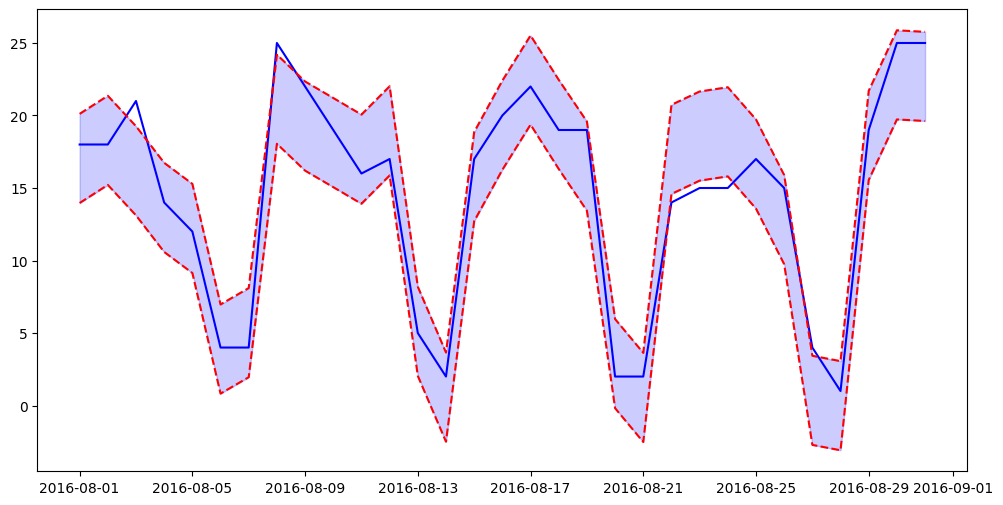

In [50]:
plt.figure(figsize=(12,6))
plt.plot(station_2['DATE_ST'],station_2['NO_TRIP'],label='No Trip',color='b')
plt.fill_between(station_2['DATE_ST'],station_2['lower_bound'],station_2['upper_bound'],color='b',alpha=0.2,label='Anomaly')
plt.plot(station_2['DATE_ST'],station_2['lower_bound'],label='lower_bound',color='r',linestyle='--')
plt.plot(station_2['DATE_ST'],station_2['upper_bound'],label='upper_bound',color='r',linestyle='--')
plt.show()

In [18]:
query_papams = [
    bigquery.ScalarQueryParameter("subscriber_type", "STRING", "Customer"),
]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_papams

sql = """ SELECT * FROM `bigquery-public-data.san_francisco.bikeshare_trips` 
WHERE subscriber_type = @subscriber_type
  """

query_job = client.query(sql, job_config=job_config)
query_job.result()
df_result = query_job.to_dataframe()
print(" query results loaded to the table")

 query results loaded to the table


In [19]:
df_result

,trip_id,duration_sec,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_number,zip_code,subscriber_type
0,1235850,1540,2016-06-11 08:19:00+00:00,San Jose Diridon Caltrain Station,2,2016-06-11 08:45:00+00:00,San Jose Diridon Caltrain Station,2,124,15206,Customer
1,1219337,6324,2016-05-29 12:49:00+00:00,San Jose Diridon Caltrain Station,2,2016-05-29 14:34:00+00:00,San Jose Diridon Caltrain Station,2,174,55416,Customer
2,793762,115572,2015-06-04 09:22:00+00:00,San Jose Diridon Caltrain Station,2,2015-06-05 17:28:00+00:00,San Jose Diridon Caltrain Station,2,190,95391,Customer
3,453845,54120,2014-09-15 16:53:00+00:00,San Jose Diridon Caltrain Station,2,2014-09-16 07:55:00+00:00,San Jose Diridon Caltrain Station,2,127,81,Customer
4,1245113,5018,2016-06-17 20:08:00+00:00,San Jose Diridon Caltrain Station,2,2016-06-17 21:32:00+00:00,San Jose Diridon Caltrain Station,2,153,95070,Customer
...,...,...,...,...,...,...,...,...,...,...,...
136804,1323441,102,2016-08-19 16:56:00+00:00,Cyril Magnin St at Ellis St,91,2016-08-19 16:58:00+00:00,Cyril Magnin St at Ellis St,91,473,55104,Customer
136805,1327216,7913,2016-08-23 14:02:00+00:00,Cyril Magnin St at Ellis St,91,2016-08-23 16:14:00+00:00,Cyril Magnin St at Ellis St,91,377,90049,Customer
136806,1320788,564,2016-08-18 06:41:00+00:00,Cyril Magnin St at Ellis St,91,2016-08-18 06:50:00+00:00,Cyril Magnin St at Ellis St,91,295,20025,Customer
136807,1320548,7000,2016-08-17 18:26:00+00:00,Cyril Magnin St at Ellis St,91,2016-08-17 20:22:00+00:00,Cyril Magnin St at Ellis St,91,226,nil,Customer


In [ ]:
sql = """
SELECT * FROM `bigquery-public-data.covid19_geotab_mobility_impact.city_congestion` 
 """
model_creation = client.query(sql).to_dataframe()